In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

Device:  cuda


In [2]:
from models.SatelliteDataset import SatelliteDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms

transform_data = transforms.Compose([
  transforms.ToTensor()
])

transform_truth = transforms.Compose([
  transforms.ToTensor(),
  transforms.Grayscale()
])

dataset = SatelliteDataset('images', 'truth', transform_data=transform_data, transform_truth=transform_truth)
train, test, dev = random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(train, batch_size=4, shuffle=True)
test_loader = DataLoader(test, batch_size=2, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2, shuffle=True)

In [3]:
from models.Model import Model

model = Model().to(device)
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model: {model}")

c:\Users\topra\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Total Parameters: 44238848
Model: Model(
  (embed): PatchPositionalEmbedding(
    (unfold): Unfold(kernel_size=8, dilation=1, padding=0, stride=8)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder

In [4]:
from torch.optim import Adam
from torch.nn import MSELoss

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.00001)

In [5]:
import matplotlib.pyplot as plt
import torch
import gc
import tqdm

EPOCHS = 100

model.train(True)
for epoch in range(EPOCHS):

  for data, target in tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}'):
    data, target = data.to(device), target.to(device)
    # Clear the gradients
    optimizer.zero_grad()

    # Make predictions
    output = model(data)

    # Compute the loss and grads
    loss = loss_function(output, target.squeeze(1))
    loss.backward()

    # Update parameters
    optimizer.step()        

    del data, target 
    torch.cuda.empty_cache()

  model.zero_grad()
  gc.collect()


Epoch 1:   0%|          | 0/440 [00:00<?, ?it/s]


TypeError: Transformer.forward() missing 1 required positional argument: 'tgt'

In [20]:
# Save parameters
torch.save(model.state_dict(), 'results/model.pth')

C:\Users\topra\AppData\Local\Temp\ipykernel_6172\1414424343.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


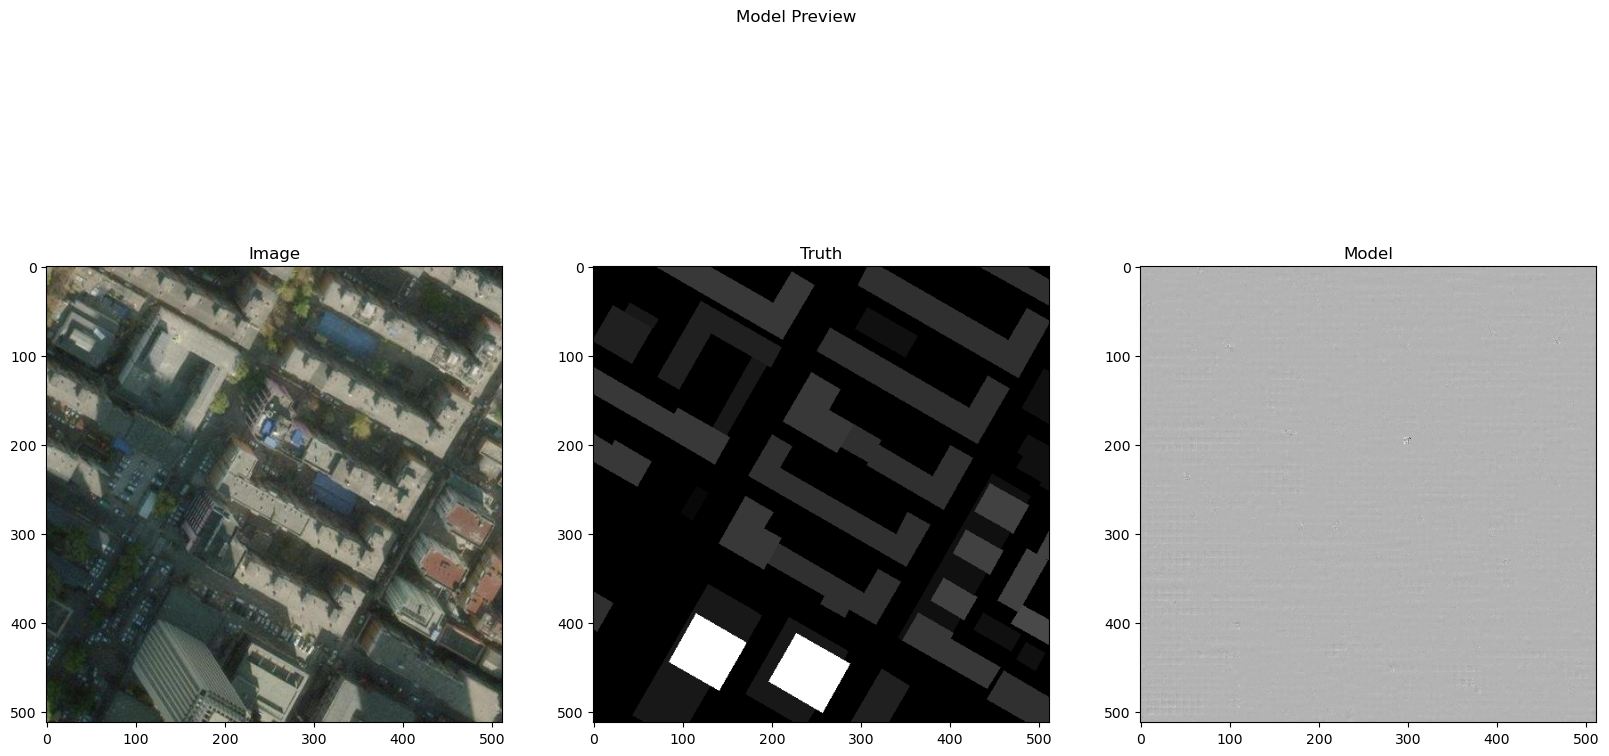

In [22]:
image, truth = dataset[0]
image, truth = image.unsqueeze(0).to(device), truth.unsqueeze(0).to(device)
preview: torch.tensor = model(image)
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Model Preview')
ax[0].imshow(image[0].cpu().permute(1, 2, 0))
ax[0].set_title('Image')
ax[1].imshow(truth[0].cpu().detach().permute(1, 2, 0), cmap='gray')
ax[1].set_title('Truth')
ax[2].imshow(preview[0].cpu().detach(), cmap='gray')
ax[2].set_title('Model')
fig.show() 